In [1]:
ROOT_DIR = '2016-01-27-OrangeTank-5galSteps'

In [3]:
import os
import itertools
import pandas as pd
import numpy as np
import datetime
import re


def parse_datetime(line):
    return datetime.datetime.strptime(line[5:], '%Y-%m-%d %H:%M:%S.%f')


def parse_temperature(line):
    return float(line[14:-3])


def parse_pressure(line):
    return float(line[22:-5])


def parse_battery_voltage(line):
    return float(line[24:-6])


def parse_pot_setting(line):
    values = re.sub(r'[A-z;=>:]', ' ', line.replace('POT1', '').replace('POT2', '')).split()
    return map(float, values)

def parse_gallons(gal_dir_name):
    return float(re.sub(r'[^\d]', '', gal_dir_name))


def yield_gallon_dir(sample_dir, root_dir=ROOT_DIR):
    gallons = parse_gallons(sample_dir)
    sample_files = os.listdir(os.path.join(root_dir, sample_dir))
    for sample_file in sample_files:
        with open(os.path.join(root_dir, sample_dir, sample_file)) as f:
            lines = map(lambda l: l[:-1], f)
            pot_values = parse_pot_setting(lines[4])
            yield {
                'gallons': gallons,
                'datetime': parse_datetime(lines[0]),
                'temperature': parse_temperature(lines[1]),
                'pressure': parse_pressure(lines[2]),
                'battery_voltage': parse_battery_voltage(lines[3]),
                'pot_setting1': pot_values[0],
                'pot_setting2': pot_values[1],
                'pot_setting3': pot_values[2],
                'sample': np.array(map(int, lines[5:]))
            } 

In [4]:
samples_dirs = filter(lambda d: d.endswith('gallon'), os.listdir(ROOT_DIR))


samples_df = pd.DataFrame(list(
    itertools.chain.from_iterable((yield_gallon_dir(d, ROOT_DIR) for d in samples_dirs))
))

print samples_df.shape
samples_df.sample(10)

(1840, 9)


,battery_voltage,datetime,gallons,pot_setting1,pot_setting2,pot_setting3,pressure,sample,temperature
112,6.10,2016-01-27 16:35:48.827166,5,192,127,12.5,29.09,"[4095, 907, 2050, 1861, 3459, 76, 2682, 4095, ...",15.2
1033,6.15,2016-01-30 14:28:09.656167,215,192,127,12.5,28.60,"[67, 4095, 2159, 1089, 1858, 2724, 1294, 4095,...",20.2
1301,6.12,2016-01-28 21:31:31.347850,100,192,127,12.5,28.47,"[277, 3150, 3791, 2554, 129, 4095, 1603, 1616,...",15.3
72,6.11,2016-01-30 15:23:17.438419,225,192,127,12.5,28.60,"[4095, 1758, 1458, 1240, 4095, 1183, 2443, 361...",15.6
1659,5.92,2016-01-29 23:34:57.996422,210,192,127,12.5,28.84,"[1452, 3283, 580, 4095, 848, 1017, 1999, 1897,...",10.0
452,6.10,2016-01-28 22:14:38.541464,110,192,127,12.5,28.48,"[1235, 1224, 2654, 2232, 1129, 3208, 2515, 409...",14.9
589,6.06,2016-01-27 17:00:06.801747,10,192,127,12.5,29.09,"[1240, 3411, 996, 1432, 4055, 1699, 357, 3631,...",14.6
141,6.00,2016-01-27 20:52:09.988623,55,192,127,12.5,28.98,"[4095, 1399, 2633, 1866, 3558, 175, 2279, 3960...",12.7
696,5.91,2016-01-29 22:33:14.649623,200,192,127,12.5,28.85,"[1110, 4095, 915, 1930, 4095, 401, 3262, 4037,...",11.2
1360,6.09,2016-01-28 22:36:28.352437,115,192,127,12.5,28.48,"[4095, 2013, 2725, 1049, 3400, 1101, 2547, 282...",14.6


In [5]:
import scipy as sp
import sklearn
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.metrics

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 5)


def list_to_matrix(list_like):
    if sp.sparse.issparse(list_like[0]):
        return sp.sparse.vstack(list_like)
    else:
        return np.vstack(list_like)

    

def vectorize(df):
    df_columns = [df.ix[:, i].values for i in range(df.shape[1])]
    df_matrixes = map(list_to_matrix, df_columns)

    if any([sp.sparse.issparse(m) for m in df_matrixes]):
        X = sp.sparse.hstack(df_matrixes).tocsr()
    else:
        X = np.hstack(df_matrixes)
    return X


def regression_report(model, X, y):
    y_pred = model.predict(X)
    
    print '\t MSE: {:.3f}'.format(sklearn.metrics.mean_squared_error(y, y_pred))
    print '\t MAE: {:.3f}'.format(sklearn.metrics.mean_absolute_error(y, y_pred))
#     print '\t R2: {:.2f}'.format(sklearn.metrics.r2_score(y, y_pred))
    
    print '\t Relative MSE: {:.5f}'.format(sklearn.metrics.mean_squared_error(y / 225, y_pred / 225))
    print '\t Relative MAE: {:.5f}'.format(sklearn.metrics.mean_absolute_error(y / 225, y_pred / 225))
    
    
def regression_report_train_valid(model, X_train, X_valid, y_train, y_valid, fit=True):
    if fit==True:
        model.fit(X_train, y_train)
    print 'Train:'
    regression_report(model, X_train, y_train)
    print 'Valid:'
    regression_report(model, X_valid, y_valid)
    
    y_valid_pred = model.predict(X_valid)
    plt.figure(figsize=(6, 4))
    sns.distplot(y_valid - y_valid_pred, bins=40, label='AAA', axlabel='Validation residuals')

Populating the interactive namespace from numpy and matplotlib


/home/obus/.venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


In [84]:
np.exp(0.1 * X_raw_train[0,:])

array([ 1.14101294,  1.14948323,  0.87494975, ...,  0.91605841,
        0.81110347,  0.96708112])

In [86]:
import sklearn.base

class ExpTransformer(sklearn.base.TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.exp(X * 0.1)

In [87]:
scaler = sklearn.preprocessing.StandardScaler()

X_raw = np.vstack(samples_df['sample'].values)
X_raw = scaler.fit_transform(X_raw)

y = samples_df.gallons.values

X_raw_train, X_raw_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(
    X_raw, y, train_size=0.7, random_state=419)


import sklearn.feature_extraction
import sklearn.decomposition
import sklearn.pipeline
svd = sklearn.decomposition.TruncatedSVD(
    n_components=20, 
    random_state=419,
    algorithm='randomized'
)
tfidf_svd = sklearn.pipeline.Pipeline([
        ('tfidf', sklearn.feature_extraction.text.TfidfTransformer),
        ('svd', sklearn.decomposition.TruncatedSVD(
            n_components=20, 
            random_state=419,
            algorithm='randomized'
        ))
        ])
nmf = sklearn.pipeline.Pipeline([
        ('exp', ExpTransformer()),
        ('nmf', sklearn.decomposition.NMF(n_components=20))
        ])
nmf_reg = sklearn.pipeline.Pipeline([
        ('exp', ExpTransformer()),
        ('nmf', sklearn.decomposition.NMF(n_components=20, l1_ratio=0.5, alpha=0.1))
        ])
ica = sklearn.decomposition.FastICA(n_components=20)

feature_extraction = sklearn.pipeline.FeatureUnion([
        ('svd', svd),
#         ('tfidf_svd', tfidf_svd),
        ('nmf', nmf),
        ('nmf_reg', nmf_reg),
        ('ica', ica)
    ])

X_train = feature_extraction.fit_transform(X_raw_train)
X_valid = feature_extraction.transform(X_raw_valid)


print 'Train size: {0}, validation size: {1}'.format(X_train.shape[0], X_valid.shape[0])

/home/obus/.venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/obus/.venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train size: 1288, validation size: 552


In [88]:
y_train.mean(), y_valid.mean()

(112.4417701863354, 112.63586956521739)

In [94]:
X_train1 = X_train
X_valid1 = X_valid
y_train1 = y_train
y_valid1 = y_valid

Train:
	 MSE: 1451.399
	 MAE: 30.121
	 Relative MSE: 0.02867
	 Relative MAE: 0.13387
Valid:
	 MSE: 1746.281
	 MAE: 33.664
	 Relative MSE: 0.03449
	 Relative MAE: 0.14962


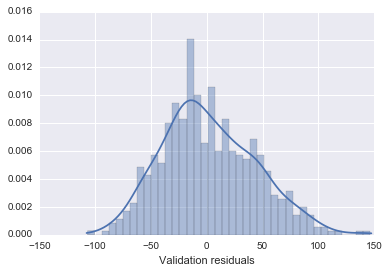

In [90]:
model_lr = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)

model = model_lr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   20.0s finished


Train:
	 MSE: 204.342
	 MAE: 4.874
	 Relative MSE: 0.00404
	 Relative MAE: 0.02166
Valid:
	 MSE: 1702.588
	 MAE: 30.452
	 Relative MSE: 0.03363
	 Relative MAE: 0.13534


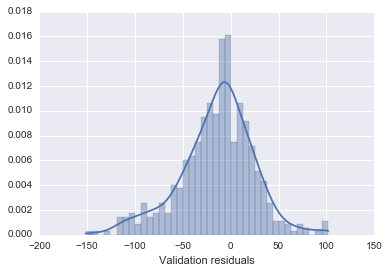

In [92]:
model_svr = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
#         'C': [200, 400, 800],
        'C': [0.1, 1, 10, 100, 500],
        'gamma': [4**i for i in range(-7, 2)],
        'cache_size': [1]
    },
    refit=True,
    n_jobs=4,
    cv=3,
    verbose=True
)
model = model_svr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [93]:
model_svr.best_params_

{'C': 100, 'cache_size': 1, 'gamma': 0.00390625, 'kernel': 'rbf'}

In [10]:
# import sklearn.ensemble

# model_rf = sklearn.ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=2, max_features=20, max_leaf_nodes=None,
#             min_samples_leaf=5, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)

# model = model_rf

# regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [95]:
features_names = ['battery_voltage','pot_setting1','pot_setting2','pot_setting3','pressure','temperature']
X_raw = samples_df[features_names]


X = vectorize(X_raw)
y = samples_df.gallons.values

X_train, X_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(
    X, y, train_size=0.7, random_state=419)


print 'Train size: {0}, validation size: {1}'.format(X_train.shape[0], X_valid.shape[0])

Train size: 1288, validation size: 552


Train:
	 MSE: 2202.619
	 MAE: 36.148
	 Relative MSE: 0.04351
	 Relative MAE: 0.16066
Valid:
	 MSE: 1931.352
	 MAE: 35.385
	 Relative MSE: 0.03815
	 Relative MAE: 0.15727


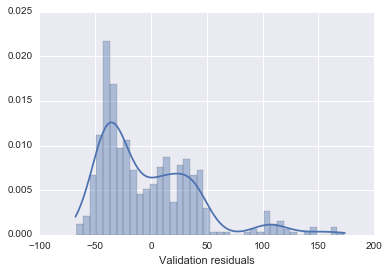

In [39]:
model_lr = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)

model = model_lr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:   10.4s finished


Train:
	 MSE: 21.800
	 MAE: 2.159
	 Relative MSE: 0.00043
	 Relative MAE: 0.00959
Valid:
	 MSE: 110.065
	 MAE: 3.422
	 Relative MSE: 0.00217
	 Relative MAE: 0.01521


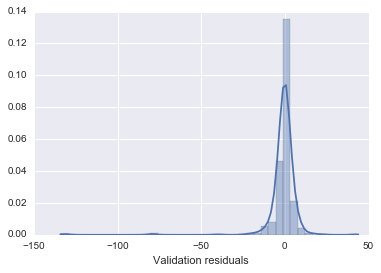

In [96]:
model_svr = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
#         'C': [200, 400, 800],
        'C': [1, 10, 1000, 2000],
        'gamma': [4**i for i in range(-7, 2)],
        'cache_size': [1]
    },
    refit=True,
    n_jobs=4,
    cv=3,
    verbose=True
)
model = model_svr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [101]:
model_svr.best_params_

{'C': 2000, 'cache_size': 1, 'gamma': 4, 'kernel': 'rbf'}

In [111]:
def drop_i(X, i):
    lX = X[:, :i]
    rX = X[:, (i+1):]
    X_no_i = np.hstack((lX, rX))
    return X_no_i
    
for i in range(X.shape[1]):
    X_train_no_i = drop_i(X_train, i)
    X_valid_no_i = drop_i(X_valid, i)

    model = sklearn.svm.SVR(kernel='rbf', C=1000, gamma=4)
    model.fit(X_train_no_i, y_train)

    y_valid_pred = model.predict(X_valid_no_i)
    relative_mae = sklearn.metrics.mean_absolute_error(y_valid / 225, y_valid_pred / 225)
    print features_names[i], '\t', relative_mae

battery_voltage 	0.0222022034976
pot_setting1 	0.0159996994983
pot_setting2 	0.0159998259246
pot_setting3 	0.0159998259246
pressure 	0.0816183777352
temperature 	0.0336859481586


In [109]:
X_valid_no_i.shape

(1288, 5)

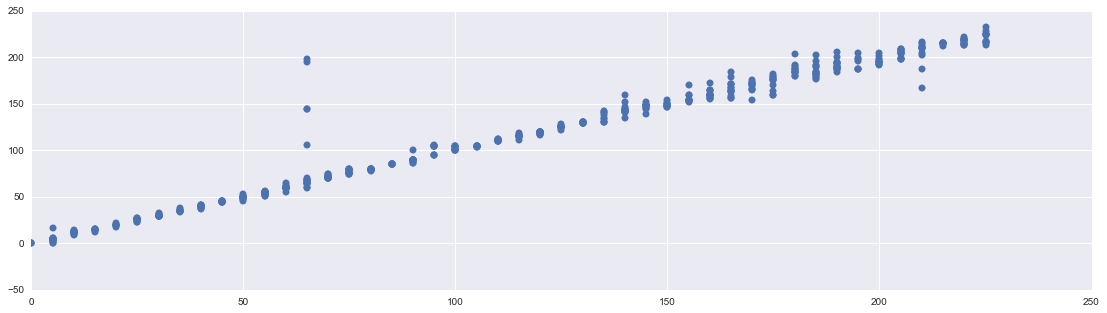

In [97]:
plt.plot(y_valid, model_svr.predict(X_valid), 'o')

In [59]:
scaler = sklearn.preprocessing.StandardScaler()

sample_X_raw = np.vstack(samples_df['sample'].values)
sample_X_raw = scaler.fit_transform(sample_X_raw)

features_names = ['battery_voltage','pot_setting1','pot_setting2','pot_setting3','pressure','temperature']
features_X = samples_df[features_names]

y = samples_df.gallons.values

sample_X_raw_train, sample_X_raw_valid, features_X_train, features_X_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(
    sample_X_raw, features_X, y, train_size=0.7, random_state=419)


import sklearn.decomposition
feature_extraction = sklearn.decomposition.TruncatedSVD(
    n_components=1, 
    random_state=419,
    algorithm='randomized'
)

sample_X_train = feature_extraction.fit_transform(sample_X_raw_train)
sample_X_valid = feature_extraction.transform(sample_X_raw_valid)


X_train = np.hstack((sample_X_train, features_X_train))
X_valid = np.hstack((sample_X_valid, features_X_valid))

# print 'Train size: {0}, validation size: {1}'.format(X_train.shape[0], X_valid.shape[0])

/home/obus/.venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/obus/.venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train:
	 MSE: 2195.324
	 MAE: 36.049
	 Relative MSE: 0.04336
	 Relative MAE: 0.16022
Valid:
	 MSE: 1923.348
	 MAE: 35.272
	 Relative MSE: 0.03799
	 Relative MAE: 0.15676


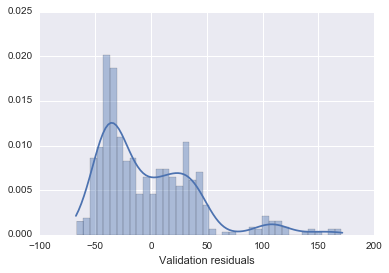

In [60]:
model_lr = sklearn.linear_model.LinearRegression(
    copy_X=True, fit_intercept=True, n_jobs=1, normalize=False
)

model = model_lr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Train:
	 MSE: 1836.934
	 MAE: 27.706
	 Relative MSE: 0.03629
	 Relative MAE: 0.12314
Valid:
	 MSE: 2129.869
	 MAE: 31.442
	 Relative MSE: 0.04207
	 Relative MAE: 0.13974


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:    0.8s finished


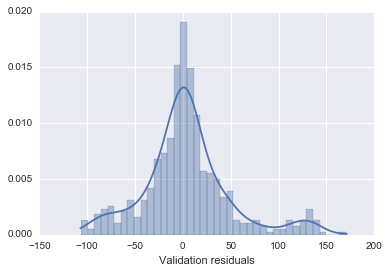

In [64]:
model_svr = sklearn.grid_search.GridSearchCV(
    estimator=sklearn.svm.SVR(),
    param_grid={
        'kernel': ['rbf'],
#         'C': [200, 400, 800],
        'C': [1, 10, 1000, 2000],
        'gamma': [4**i for i in range(-7, 2)],
        'cache_size': [1]
    },
    refit=True,
    n_jobs=4,
    cv=3,
    verbose=True
)
model = model_svr

regression_report_train_valid(model, X_train, X_valid, y_train, y_valid)

In [62]:
model_svr.best_params_

{'C': 2000, 'cache_size': 1, 'gamma': 0.015625, 'kernel': 'rbf'}

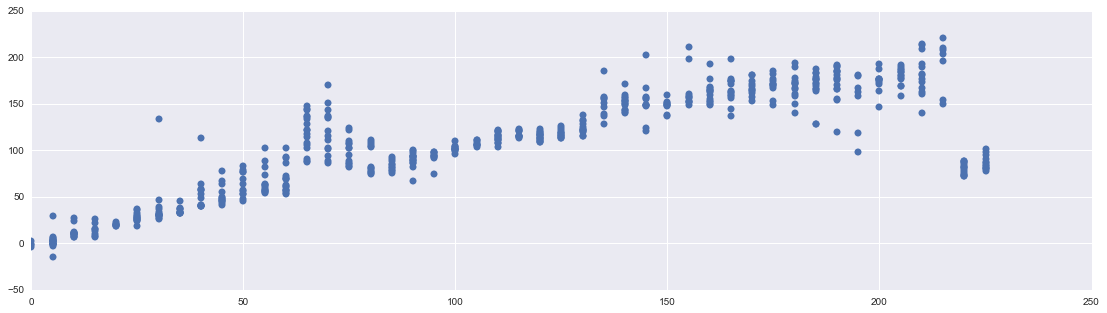

In [63]:
plt.plot(y_valid, model_svr.predict(X_valid), 'o')